This code is a modification of Chris McCormick's 'BERT Application Examples: Named Entity Recognition', so that it can handle MWE identification problem, specifically DiSUM dataset.

Chris McCormick's website: https://mccormickml.com/tutorials/

DiMSUM dataset: http://dimsum16.github.io

In [1]:
!pip install transformers
!unzip ./dimsum.zip

     |████████████████████████████████| 1.3MB 3.5MB/s 
     |████████████████████████████████| 890kB 12.7MB/s 
     |████████████████████████████████| 1.1MB 24.6MB/s 
     |████████████████████████████████| 2.9MB 37.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d461c7fb4895fe6146969b9415024b35a656cc09702e81cc9edd9ad057e517f8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Archive:  ./dimsum.zip
3af1dd34ce49783e0ab99f31e989dd6171f75433
   creating: dimsum-data-master/
  inflating: dimsum-data-master/README.md  
  inflating: dimsum-data-master/TAGSET.md  
   creating: dimsum-data-master/conversion/
  inflating: dimsum-data-master/conversion/convert.sh  
  inflating: dimsum-data-master/conversion/mwe_simplify.py  
   creating: dimsum-data-master/conversion/original/
  inflating: dimsum-data-master/conversion/original/lowlands.UPOS2.tsv  
  infla

In [2]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
import csv

sentences = []
labels = []
tokens = []
token_labels = []
unique_labels = set()

with open("./dimsum-data-master/dimsum16.train", newline = '') as lines:
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        if line == []:
            sentences.append(tokens)
            labels.append(token_labels)           

            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            pre_label = {'B':'O', 'b':'o', 'I':'o', 'i':'o', 'O':'O', 'o':'o'}  # ('#token', 'B') => ('#'+'token','O'+'B')
            post_label = {'B': 'I', 'b':'i', 'I':'I', 'i':'i', 'O':'O', 'o':'o'}  # ('token%', 'B') => ('token'+'%', 'B'+'I')

            # truncate white space token
            # since BERT tokenizer will truncate it, anyway,
            # it is easier to truncate it in advanced
            line[1] = line[1].strip()
            if len(line[1]) == 0:
                continue

            # seperate '#word' to '#' + 'word'
            if line[1].startswith(('@','#','$')) and len(line[1]) > 1:
              tokens.append(line[1][:1])
              line[1] = line[1][1:]
              token_labels.append(pre_label[line[4]])
            
            # seperate '00%' to '00' + '%'
            if line[1].endswith('%') and len(line[1]) > 1:
              tokens.append(line[1][:-1])
              tokens.append(line[1][-1:])
              token_labels.append(line[4])
              token_labels.append(post_label[line[4]])
              continue

            tokens.append(line[1])
            token_labels.append(line[4])

              # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[4])

In [4]:
#label_map = {}
#for (i, label) in enumerate(unique_labels):
#    label_map[label] = i

label_map = {'O':0, 'B':1, 'I':2, '0':3, 'o':4, 'b':5, 'i':6}

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Sentences')

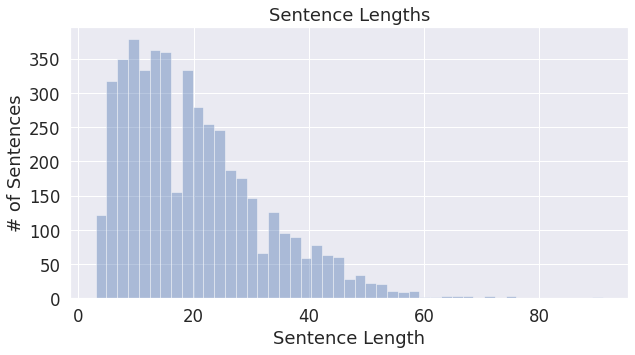

In [5]:
from transformers import BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
lengths = []

for sen in sentences:
    sen = ' '.join(sen)
    encoded_sent = tokenizer.encode(sen, add_special_tokens = True)
    lengths.append(len(encoded_sent))

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')

In [6]:
input_ids = []
attention_masks = []

for sent in sentences:
    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 100,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

In [7]:
new_labels = []
null_label_id = -100

for i, (sen, orig_labels, orig_sen) in enumerate(zip(input_ids, labels, sentences)):
    padded_labels = []

    orig_labels_i = 0 
    consumed = 0
    print(i)
    for token_id in sen:
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)
            continue

        orig_token = orig_sen[orig_labels_i].lower()
        token = tokenizer.ids_to_tokens[token_id]

        print(orig_token, ', ', token)

        # token is non-first subword of orig_token
        if token[:2] == '##':
            assert consumed > 0, f'[{token}] which starts with ## should be subword'
            assert token[2] != '#', 'it is ###'
            token = token[2:]

        # truncation
        while len(orig_token) < len(token):
            assert orig_token == '\t', f'unexpected truncation : [{orig_token}]'
            orig_labels_i += 1
            orig_token = orig_sen[orig_labels_i].lower()
            print('truncation happend, below is next orig_token')
            print(orig_token, ',', token)

        # everything is happy, no truncation, no subword
        if len(orig_token) == len(token) and consumed == 0:
            assert orig_token == token, f'[{token}] should be same with [{orig_token}], something wrong!'
            label_str = orig_labels[orig_labels_i]
            padded_labels.append(label_map[label_str])
            orig_labels_i += 1
            continue
        
        # len(orig_token) > len(token), 
        # token is subword of orig_token
        assert token in orig_token, f'{token} should be in {orig_token}'
        
        # subword default label
        token_label_id = null_label_id

        # token is first subword of orig_token
        if consumed == 0:
            assert orig_token[:len(token)] == token, f'[{token}] should be first subword of [{orig_token}]'            
            label_str = orig_labels[orig_labels_i]
            # first subword takes real label
            token_label_id = label_map[label_str]

        # strip orig_token
        # since BERT tokenizer will tokenize ['   '] to ['] + [']
        whitespace_offset = len(orig_token[consumed:]) - len(orig_token[consumed:].lstrip())
        consumed += whitespace_offset
        assert orig_token[consumed:consumed+len(token)] == token, f'[{token}] should be subword of [{orig_token}]'
        
        padded_labels.append(token_label_id)
        consumed += len(token)

        assert consumed <= len(orig_token), f'sum of subword length [{consumed}] exceeds {token}'
        
        # token is last subword of orig_token
        if consumed == len(orig_token):
            print(f'the last subword [{token}]')
            assert orig_token[-len(token):] == token, f'{token} should be last subword of {orig_token}'
            orig_labels_i += 1
            consumed = 0
        

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels)), f'{len(sen)}, {len(padded_labels)}'

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
n't ,  t
the last subword [t]
expect ,  expect
a ,  a
miracle ,  miracle
, ,  ,
but ,  but
after ,  after
2 ,  2
months ,  months
i ,  i
felt ,  felt
like ,  like
it ,  it
was ,  was
not ,  not
entirely ,  entirely
worth ,  worth
the ,  the
cost ,  cost
/ ,  /
time ,  time
. ,  .
4458
great ,  great
cookies ,  cookies
, ,  ,
cakes ,  cakes
, ,  ,
and ,  and
customer ,  customer
service ,  service
4459
although ,  although
i ,  i
'll ,  '
'll ,  ll
the last subword [ll]
have ,  have
to ,  to
drive ,  drive
a ,  a
little ,  little
out ,  out
of ,  of
my ,  my
way ,  way
to ,  to
go ,  go
there ,  there
, ,  ,
i ,  i
'll ,  '
'll ,  ll
the last subword [ll]
gladly ,  gladly
do ,  do
it ,  it
knowing ,  knowing
that ,  that
since ,  since
she ,  she
's ,  '
's ,  s
the last subword [s]
been ,  been
astounding ,  as
astounding ,  ##tou
astounding ,  ##nding
the last subword [nding]
to ,  to
me ,  me
once ,  once
before ,  before
that ,  that
she ,  she
'l

In [8]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [9]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
batch_size = 32

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), 
                                   batch_size = batch_size)

In [10]:
from transformers import BertForTokenClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# Model
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", num_labels = len(label_map) + 1,
    output_attentions = False, output_hidden_states = False,
)
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

# Scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [12]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, 
                    attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
  Batch    40  of    135.    Elapsed: 0:00:37.
  Batch    80  of    135.    Elapsed: 0:01:14.
  Batch   120  of    135.    Elapsed: 0:01:51.

  Average training loss: 0.39
  Training epcoh took: 0:02:05

======== Epoch 2 / 4 ========
  Batch    40  of    135.    Elapsed: 0:00:38.
  Batch    80  of    135.    Elapsed: 0:01:15.
  Batch   120  of    135.    Elapsed: 0:01:53.

  Average training loss: 0.17
  Training epcoh took: 0:02:07

======== Epoch 3 / 4 ========
  Batch    40  of    135.    Elapsed: 0:00:38.
  Batch    80  of    135.    Elapsed: 0:01:15.
  Batch   120  of    135.    Elapsed: 0:01:53.

  Average training loss: 0.10
  Training epcoh took: 0:02:07

======== Epoch 4 / 4 ========
  Batch    40  of    135.    Elapsed: 0:00:38.
  Batch    80  of    135.    Elapsed: 0:01:15.
  Batch   120  of    135.    Elapsed: 0:01:53.

  Average training loss: 0.06
  Training epcoh took: 0:02:07


###Save Parameters

In [34]:
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

### TEST

In [35]:
import csv

sentences = []
labels = []
tokens = []
token_labels = []
unique_labels = set()

with open("./dimsum-data-master/dimsum16.test", newline = '') as lines:
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        if line == []:
            sentences.append(tokens)
            labels.append(token_labels)           

            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            pre_label = {'B':'O', 'b':'o', 'I':'o', 'i':'o', 'O':'O', 'o':'o'}  # ('#token', 'B') => ('#'+'token','O'+'B')
            post_label = {'B': 'I', 'b':'i', 'I':'I', 'i':'i', 'O':'O', 'o':'o'}  # ('token%', 'B') => ('token'+'%', 'B'+'I')

            # truncate white space token
            # since BERT tokenizer will truncate it, anyway,
            # it is easier to truncate it in advanced
            line[1] = line[1].strip()
            if len(line[1]) == 0:
                continue

            # seperate '#word' to '#' + 'word'
            if line[1].startswith(('@','#','$')) and len(line[1]) > 1:
              tokens.append(line[1][:1])
              line[1] = line[1][1:]
              token_labels.append(pre_label[line[4]])
            
            # seperate '00%' to '00' + '%'
            if line[1].endswith('%') and len(line[1]) > 1:
              tokens.append(line[1][:-1])
              tokens.append(line[1][-1:])
              token_labels.append(line[4])
              token_labels.append(post_label[line[4]])
              continue

            tokens.append(line[1])
            token_labels.append(line[4])

              # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[4])

In [36]:
input_ids = []
attention_masks = []

for sent in sentences:
    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(
                        sent_str, add_special_tokens = True,
                        max_length = 100, padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt', truncation=True,
                   )
    
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

In [43]:
new_labels = []
null_label_id = -100

for i, (sen, orig_labels, orig_sen) in enumerate(zip(input_ids, labels, sentences)):
    padded_labels = []
    orig_labels_i = 0 
    consumed = 0

    for token_id in sen:
        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)
            continue

        orig_token = orig_sen[orig_labels_i].lower()
        token = tokenizer.ids_to_tokens[token_id]

        # token is non-first subword of orig_token
        if token[:2] == '##':
            # assert consumed > 0, f'[{token}] which starts with ## should be subword'
            # assert token[2] != '#', 'it is ###'
            token = token[2:]

        # [UNK] exception
        # without this, assertion in truncation occurs
        if token =='[UNK]':
            orig_labels_i += 1
            padded_labels.append(label_map[label_str])
            continue

        # truncation
        while len(orig_token) < len(token):
            # assert orig_token == '\t', f'unexpected truncation : [{orig_token}]'
            orig_labels_i += 1
            orig_token = orig_sen[orig_labels_i].lower()
            # print(orig_token, ',', token)

        # everything is happy, no truncation, no subword
        if len(orig_token) == len(token) and consumed == 0:
            # assert orig_token == token, f'[{token}] should be same with [{orig_token}], something wrong!'
            label_str = orig_labels[orig_labels_i]
            padded_labels.append(label_map[label_str])
            orig_labels_i += 1
            continue
        
        # len(orig_token) > len(token), 
        # token is subword of orig_token
        # assert token in orig_token, f'{token} should be in {orig_token}'
        
        # subword default label
        token_label_id = null_label_id

        # token is first subword of orig_token
        if consumed == 0:
            # assert orig_token[:len(token)] == token, f'[{token}] should be first subword of [{orig_token}]'            
            label_str = orig_labels[orig_labels_i]
            # first subword takes real label
            token_label_id = label_map[label_str]

        # strip orig_token
        # since BERT tokenizer will tokenize ['   '] to ['] + [']
        whitespace_offset = len(orig_token[consumed:]) - len(orig_token[consumed:].lstrip())
        consumed += whitespace_offset
        # assert orig_token[consumed:consumed+len(token)] == token, f'[{token}] should be subword of [{orig_token}]'
        
        padded_labels.append(token_label_id)
        consumed += len(token)

        # assert consumed <= len(orig_token), f'sum of subword length [{consumed}] exceeds {token}'
        
        # token is last subword of orig_token
        if consumed == len(orig_token):
            # assert orig_token[-len(token):] == token, f'{token} should be last subword of {orig_token}'
            orig_labels_i += 1
            consumed = 0
        

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    # assert(len(sen) == len(padded_labels)), f'{len(sen)}, {len(padded_labels)}'

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


In [44]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [45]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [46]:
predictions , true_labels = [], []

model.eval()

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

In [47]:
from sklearn.metrics import f1_score

all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

predicted_label_ids = np.argmax(all_predictions, axis=2)
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

real_token_predictions = []
real_token_labels = []

# Remove NULL label(-100)
for i in range(len(all_true_labels)):
    if not all_true_labels[i] == -100:
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 
print ("F1 score: {:.2%}".format(f1))

F1 score: 91.43%
